# Create MISP objects and relationships

## Introduction

- UUID: **c0f920a6-37e1-47bb-92b8-1491dc710d39**
- Started from [issue 11](https://github.com/MISP/misp-playbooks/issues/11)
- State: **published** : demo version with **output**
- Purpose: This playbook walks the analyst through the phases of creating MISP objects and adding a relationship between these objects. 
- - The playbook is typically *triggered* when an an analyst wants to add related, contextually linked, attributes to a MISP event.
- - The objects are added to a new or an existing MISP event. The playbook prints out a summary that can be used to notify colleagues via Mattermost or other channels.
- - The playbook uses an Emotet sample to demonstrate the functionality, with links from a file object to URL and HTTP request objects. It also creates the victim objects.
- Tags: [ "objects", "context" ]
- Target audience: **SOC, CSIRT, CTI**

![helpers/playbook-create_MISP_objects_and_relationships.png](helpers/playbook-create_MISP_objects_and_relationships.png)

# Playbook

- **Create MISP objects and relationships**
- - Introduction
- **Preparation**
- - PR:1 Initialise environment
- - PR:2 Load helper functions
- - PR:3 Set helper variables
- - PR:4 MISP event details
- - PR:5 Setup MISP event link
- - PR:6 Intro on MISP objects
- **Investigate**
- - IN:1 User input on the file sample
- - IN:2 Categorisation and case context details
- - IN:3 Create MISP objects
- - IN:4 Add a file object
- - IN:5 Add the URL and HTTP request objects
- - IN:6 Add the victim objects
- - IN:7 Create object relationships
- - IN:8 Event graphs
- **Extending MISP objects**
- - EX:1 Extending the default list of MISP objects
- - EX:2 Add custom MISP objects
- - EX:3 Update custom MISP objects
- - EX:4 Update the custom MISP object via the web user interface
- - EX:5 Delete objects from an event
- **Summary**
- - EN:1 MISP indicators
- - EN:2 Create the summary of the playbook
- - EN:3 Print the summary of the playbook
- - EN:4 Publish MISP event
- - EN:5 End of the playbook
- External references
- Technical details


# Preparation

## PR:1 Initialise environment

This section **initialises the playbook environment** and loads the required Python libraries. 

The credentials for MISP (**API key**) and other services are loaded from the file `keys.py` in the directory **vault**. A [PyMISP](https://github.com/MISP/PyMISP) object is created to interact with MISP and the active MISP server is displayed. By printing out the server name you know that it's possible to connect to MISP. In case of a problem PyMISP will indicate the error with `PyMISPError: Unable to connect to MISP`.

The contents of the `keys.py` file should contain at least :

```
misp_url="<MISP URL>"                  # The URL to our MISP server
misp_key="<MISP API KEY>"              # The MISP API key
misp_verifycert=<True or False>        # Indicate if PyMISP should attempt to verify the certificate or ignore errors
```

In [2]:
# Initialise Python environment
import urllib3
import sys
import json
from pyfaup.faup import Faup
from prettytable import PrettyTable, MARKDOWN
from IPython.display import Image, display, display_markdown, HTML
from datetime import date
import requests
import uuid
from uuid import uuid4
from pymisp import *
from pymisp.tools import GenericObjectGenerator

# Load the credentials
sys.path.insert(0, "../vault/")
from keys import *
if misp_verifycert is False:
    import urllib3
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
print("The \033[92mPython libraries\033[90m are loaded and the \033[92mcredentials\033[90m are read from the keys file.")

# Create the PyMISP object
misp = PyMISP(misp_url, misp_key, misp_verifycert)
print("I will use the MISP server \033[92m{}\033[90m for this playbook.\n\n".format(misp_url))

The Python libraries are loaded and the credentials are read from the keys file.
I will use the MISP server https://misp.demo.cudeso.be/ for this playbook.




## PR:2 Load helper functions

The next cell contains **helper functions** that are used in this playbook. 

Instead of distributing helper functions as separate Python files this playbook includes all the required code as one code cell. This makes portability of playbooks between instances easier. The downside is that functions defined in this playbook need to be defined again in other playbooks, which is not optimal for code re-use. For this iteration of playbooks it is chosen to include the code in the playbook (more portability), but you can easily create one "helper" file that contains all the helper code and then import that file in each playbook (for example by adding to the previous cell `from helpers import *`). Note that the graphical workflow image is included as an external image. A missing image would not influence the further progress of the playbook.

To avoid cluttering the output of the playbook the next code cell is **collapsed**. You still **need to execute it**, but you can leave the cell collapsed. Click on the cell to expand it, click on the left bar that indicates the active cell in the Jupyter notebook to collapse it again.

In [3]:
def pb_print_object_definition(misp, object_template):
    '''
    Print the raw object template

    :param misp: MISP object
    :param object_template: which object template to return
    '''

    if object_template:
        object_definition = misp.get_raw_object_template(object_template)  # get_raw_object_template does not support pythonify
        if "errors" not in object_definition:
            from prettytable import PrettyTable
            object_definition_table = PrettyTable()
            object_definition_table.title = "MISP object definition for '{}'".format(object_template)
            object_definition_table.field_names = ["Object attribute name", "Description", "MISP attribute type", "Multiple allowed?"]
            object_definition_table.align["Object attribute name"] = "l"
            object_definition_table.align["Description"] = "l"
            object_definition_table.align["MISP attribute type"] = "l"
            object_definition_table.sortby = "Object attribute name"
            object_definition_table.border = True

            for attribute in object_definition["attributes"]:
                attribute_details = object_definition["attributes"][attribute]
                multiple = False
                if attribute_details.get("multiple", False):
                    multiple = True
                object_definition_table.add_row([attribute, attribute_details["description"][:50], attribute_details["misp-attribute"], multiple])
            print(object_definition_table)
            if "required" in object_definition:
                print("required", object_definition["required"])
            elif "requiredOneOf" in object_definition:
                print("requiredOneOf", object_definition["requiredOneOf"])
        else:
            print("Error: {} for template {}".format(object_definition["errors"][1]["message"], object_template))
            return False
    else:
        print("No object template supplied")
        return False

def pb_get_misp_tags(tags=[], local_tags=[]):
    '''
    Get a list of MISP tags based on a Python list

    :param misp: MISP object
    :param object_template: which object template to return
    '''
    misp_tags = []
    for el in tags:
        t = MISPTag()
        t.name = el
        t.local = False
        misp_tags.append(t)

    for el in local_tags:
        t = MISPTag()
        t.name = el
        t.local = True
        misp_tags.append(t)
    return misp_tags

print("Helper \033[92mfunctions\033[90m loaded.\n\n")

Helper functions loaded.




## PR:3 Set helper variables

This cell contains **helper variables** that are used in this playbook. Their usage is explained in the next steps of the playbook.

- `playbook_objects` : a dictionary of the objects that are created when the playbook progresses

In [4]:
playbook_objects = {}

print("Helper \033[92mvariables\033[90m loaded.\n\n")

Helper variables loaded.




## PR:4 MISP event details

### Event title

Now decide if you want to create a **new** MISP event or add data to an **existing** MISP event (referenced via its UUID). If you create a new event then its good practice to choose a self-explanatory **event title**. This event title is shown in the MISP event index and should provide you the necessary information what the event is about. You should avoid using generic event titles. Read the [Best Practices in Threat Intelligence](https://www.misp-project.org/best-practices-in-threat-intelligence.html) for further guidance.

### Contexualisation

This playbook adds event contexualisation via the **tags** that are defined in `event_additional_global_tags` (for *global* tags) and `event_additional_global_tags` (for *local* tags). As a reminder, whereas *global* tags remain attached to the events that you share with your community, the *local* tags are not shared outside your organisation. It's also a good idea to primarily use tags that are part of a [taxonomy](https://github.com/MISP/misp-taxonomies), this allows you to make the contexualisation more portable accross multiple MISP instances.

In this playbook the list of tags is build via one of the helper functions `pb_get_misp_tags`. This function takes two arguments, first a list of tags to convert as *global* tags, and secondly a list of tags to convert as *local* tags. 

### Traffic Light Protocol

The default **TLP** for this event is **<span style='color:#FFBF00'>tlp:amber</span>**. The Traffic Light Protocol (TLP) facilitates sharing of potentially sensitive information and allows for more effective collaboration. TLP is a set of four standard labels to indicate the sharing boundaries to be applied by the recipients. TLP is always set by the creator of information. You can find more information at [FIRST](https://www.first.org/tlp/). You can specify TLP via `event_tlp`.

### MISP distribution, threat level and analysis level

Optionally you can specifiy a MISP **distribution** (with `event_distribution`), **threat level** (with `event_threat_level_id`) or **analysis state** (with `event_analysis`). The event **date** is set to today via `event_date`.

If you cannot remember the options for distribution, threat level or the analysis state then use the next cell to guide you. This cell is set as **raw**. If you **change its type to code** and execute the cell you get an overview of the options available for creating a MISP event.

## PR:5 Setup MISP event link

Provide your **user input** via the variable `event_input`.

If you want to **create a new event** then provide the MISP event title in `event_input`. We will use the PyMISP function [add_event](https://pymisp.readthedocs.io/en/latest/_modules/pymisp/api.html#PyMISP.add_event) to create the MISP event.

If you want to add the results of the playbook to an **existing event**, then add the MISP event UUID to `event_input`. In this case we check that you provide a valid UUID4 and use the PyMISP function [get_event](https://pymisp.readthedocs.io/en/latest/_modules/pymisp/api.html#PyMISP.get_event) to query the MISP server for the provided UUID. We also request the response to be returned as a PyMISP object with `pythonify=True`. If the event does not exist then PyMISP will return an error.

In [5]:
# Provide the event title for a new event or valid MISP event UUID to add to an existing event
#event_input = "9cf8cac1-845e-44db-af1f-266e858d63b5"
event_input = "Demo Event Create MISP objects and relations"

# Optionally, you can change TLP, add additional event (local and global) tags, threatlevel, analysis state or distribution level
event_tlp = "tlp:amber"

# Event context
event_additional_global_tags = []                                 # This needs to be a Python list
event_additional_local_tags = ["workflow:state=\"incomplete\""]   # This needs to be a Python list

# Additional MISP event settings
event_threat_level_id = ThreatLevel.low
event_analysis = Analysis.ongoing
event_distribution = Distribution.your_organisation_only
event_date = date.today()

In [6]:
# Code block to create the event or add data to an existing event
event_input = event_input.strip()
new_event = False
misp_event = False

# Check if we received a valid UUID
try:
    uuid.UUID(str(event_input))
except ValueError:
    new_event = True

# Decide if we start with a new event or add to an existing one
if not new_event:   
    misp_event = misp.get_event(event_input, pythonify=True)
    if "errors" in misp_event:
        misp_event = False
        print("\033[91mUnable to proceed.\033[90m \nEither the MISP event does not exist or the UUID is not in the correct format.")
        print("Go back to the previous (code) cell and adjust the input.\n\n")
    else:
        print("Continue the playbook with adding data to an \033[92mexisting MISP event\033[90m: {} ({}).\n\n".format(misp_event.info, misp_event.uuid))
else:
    # Set the tags, or default to an empty list in case of wrong types
    if type(event_tlp) == str and type(event_additional_global_tags) == list and type(event_additional_local_tags) == list:
        event_additional_global_tags.append(event_tlp)
        misp_event_tags = pb_get_misp_tags(event_additional_global_tags, event_additional_local_tags)
    else:
        print("\033[91mWrong types\033[90m specified for the tags. I will not add tags to the event.")
        misp_event_tags = []
        
    # Create the PyMISP object for an event
    event = MISPEvent()
    event.info = event_input
    event.distribution = event_distribution
    event.threat_level_id = event_threat_level_id
    event.analysis = event_analysis
    event.set_date(event_date)
 
    # Create the MISP event on the server side
    misp_event = misp.add_event(event, pythonify=True)
    print("Continue the playbook with the new \033[92mcreated\033[90m MISP event ID {} with UUID {}".format(misp_event.id, misp_event.uuid))
    for el in misp_event_tags:
        misp.tag(misp_event.uuid, el, local=el.local)
        print("\033[92mAdded\033[90m event tag {}".format(el.name))
    print("\n\n")

Continue the playbook with the new created MISP event ID 2590 with UUID ead00dd5-1fc0-4c4f-93bf-0b95edcb4433
Added event tag tlp:amber
Added event tag workflow:state="incomplete"





## PR:6 Intro on MISP objects 

### What are MISP objects?

MISP objects are **containers around contextually linked attributes**. They support analysts in grouping related attributes and describing the relations that exist between the data points in a threat event. Combining these objects and relations is something that can then be used to represent the story of what is being told in a threat event.

MISP supports a large list of objects such as

- AV-signature: an antivirus detection signature;
- Domain/IP: document a tuple domain, hostname and IP address;
- File: describing a file with meta information;
- Organization: an object to describe an organization.

All these objects are available via the [MISP-Objects GitHub repository](https://github.com/MISP/misp-objects) and directly accessible from MISP (via Global Actions, List Object Templates).

### MISP objects available on your server

Execute the next cell to know how many MISP objects are available on your server.

In [7]:
misp_object_templates = misp.object_templates(pythonify=True)
print("There are \033[92m{}\033[90m MISP objects definitions available on your server.\n\n".format(len(misp_object_templates)))

There are 297 MISP objects definitions available on your server.




![helpers/playbook-create_MISP_objects_and_relationships_objects.png](helpers/playbook-create_MISP_objects_and_relationships_objects.png)

### Detailed view of MISP objects available on your server

You can get a **detailed view of the available MISP object templates** with the help of the next cell. This cell is set as raw. If you change the cell type to **code** and execute the cell you will get an overview of the object templates that are available on your server. The list is sorted according to the **name** of the object template.

### MISP object definitions

Before you add an object to MISP it is useful to know the requirements, or the attributes, that are essential for an object. You can do this by reading the documentation in the GitHub repository but you can also do this directly with the help of PyMISP. The function `get_raw_object_template` queries MISP for the raw template in your MISP server. The exact object definitions are not that relevant to execute this playbook but then can be useful if you want to further extend the playbook. 

The next cell looks up the **MISP object definitions** and prints the details in an easy to use table. This cell is set as raw. If you change the cell type to **code** and execute the cell you will get the object definitions as defined in your MISP server. This makes use of one of the helper functions `pb_print_object_definition`.

![helpers/playbook-create_MISP_objects_and_relationships_objects-definition.png](helpers/playbook-create_MISP_objects_and_relationships_objects-definition.png)

# Investigate

## IN:1 User input on the file sample 

In this playbook we assume we have a sample of **Emotet** and have been able to extract the file details as well as the URLs to which it connects.

According to [VMRay](https://www.vmray.com/glossary/emotet/), Emotet is a malware family that in its earliest iterations functioned primarily as a banking trojan that attempted to steal financial credentials by intercepting a target system’s network traffic. In later iterations, malware authors took advantage of its persistence and ability to propagate across networks to adapt it into a robust delivery mechanism for spam and even other malware, including the Qakbot and Trickbot Trojan(s), as well as the Ryuk ransomware.

In this playbook we store the extracted values in a dictionary `case_details`. In future extensions of this playbook you can let this dictionary be prefilled with information from your case handling system. This dictionary contains these fields

- `filename`    : **Filename** of the sample. Provide none or one value.
- `md5`         : **MD5** hash of the sample. Provide none or one value.
- `sha256`      : **SHA256** hash of the sample. Provide none or one value.
- `virustotal`  : An *optional* reference to a **VirusTotal Report**. Provide one URL
- `requests`    : A list of dictionaries that specify the HTTP method used to contact a specific URL, in the format { "HTTP_METHOD": "URL"}
- `victims`     : A list of victims. Provide one victim string or a list of victim strings;

You need to specify at least the **requests** key. The playbook also needs either a **filename, MD5 or SHA256** (or a combination of these keys).

### Case details

The next cell fills the dictionary `case_details` with the required **user input** and is the <font color='red'>central piece of this playbook</font>. Do not forget to complete it!

In [9]:
# Case details

case_details = {
    "filename"   : "jgm1GEN.dll",
    "md5"        : "8b3f3e3028c5c934654509cb18307dc7",
    "sha256"     : "14c829d93436c24a6c271b53dbf80f2c4419b30698aee78558c8f5494ad12c96",
    "virustotal" : "https://www.virustotal.com/gui/file/14c829d93436c24a6c271b53dbf80f2c4419b30698aee78558c8f5494ad12c96",    
    "requests"   : [{"get": "http://12.195.47.98:7080/"}, {"get": "http://67.254.13.154/"}],
    "victims"    : ["BigBrand", "AnotherBigBrand"]
    }

In [10]:
# A simple check to verify that all required fields are present.
required_fields_present = False
if len(case_details.get("requests", "")) > 0 and (len(case_details.get("filename", "")) > 0 or len(case_details.get("md5", "")) > 0 or len(case_details.get("sha256", "")) > 0):
    required_fields_present = True

if not required_fields_present:
    print("\033[91mCannot continue\033[90m when not all required fields for the investigation are provided.\n\n")
else:
    print("All required fields present. \033[92mContinue\033[90m with the investigation.\n\n")

All required fields present. Continue with the investigation.




## IN:2 Categorisation and case context details

In this section you can set the context details (tags) for the attributes that are part of the MISP objects. You can leave most of these variables to their default settings.

### PAP

The default **PAP** code is **<span style='color:green'>PAP:GREEN</span>**. In this playbook PAP is attached to the attributes. The Permissible Actions Protocol (PAP) was designed to indicate how received information can be used. It uses a colour code similar as TLP and describes how much that we accept that an attacker can detect of the current analysis state or defensive actions. Read more about PAP on the [MISP taxonomy website](https://www.misp-project.org/taxonomies.html#_pap). You can specify PAP via `attribute_pap`.

### Courses of action

The **courses of action** matrix describes passive and active actions that defenders can take with a varying type of impact on the attacker (or intrusion). In this playbook the CoA is attached to attributes. You can read more about how PAP and CoA work together in this [blog post](https://www.vanimpe.eu/2020/12/28/how-to-support-defenders-with-the-permissible-actions-protocol/). In this playbook we use
- the **discover** course of action to indicate we want to query our logs for traffic towards one of the URLs or the presence of file indicators. This is a form of **retro-search**;
- the **detect** course of action, to setup rules to detect future traffic to the URLs, as well as detecting the presence of the file indicators. This is **alerting**;
- the **deny** course of action, to deny traffic to the URLs and prevent the file from being executed on expoints. This is **blocking**.

You can specify the contextualisation via a dictionary with a course of action per attribute type via `attribute_course_of_action`. The playbook will translate the dictionary to the corresponding tags and add them to the attributes that are part of the objects.

```
attribute_course_of_action = {
    "file": ["discover", "detect", "deny"],
    "network": ["discover", "detect", "deny"]
    }
```

### Privacy

There might also be attributes that you want to keep track of but never want to share outside your organisation. You can tag these attributes with tags indicating that they are sensitive or privacy related.

- `attribute_tags_private`: Attributes that should never be shared outside your organisation, either because of their sensitivity or because of privacy related information.

### Galaxies and clusters

This playbook also adds a MISP **galaxy** referring to Emotet ([S0367](https://attack.mitre.org/software/S0367/))

In [11]:
# Set the course of action per attribute type
attribute_course_of_action = { 
    "file": ["discover", "detect", "deny"],
    "url": ["discover", "detect", "deny"],
    "domain": ["discover", "detect"],
    "subdomain": ["discover", "detect"],
}

# Default PAP
attribute_pap = "PAP:GREEN"

# Tags for "private" attributes
attribute_tags_private = pb_get_misp_tags(["tlp:red"], ["workflow:todo=\"review-for-privacy\""])

# Tags to add for linking a galaxy to Emotet.
attribute_tags_galaxy = pb_get_misp_tags(["misp-galaxy:mitre-malware=\"Emotet - S0367\""])

In [12]:
# Convert the tag matrix to something we can use for tagging the attributes
attribute_tags = {}
for target in attribute_course_of_action:
    tag_list = []
    for action in attribute_course_of_action[target]:
        if action.lower() in ["discover", "detect"]:
            tag_list.append("course-of-action:{}=\"{}\"".format("passive", action.lower()))
        elif action.lower() in ["decieve", "degrade", "deny", "destroy", "disrupt"]:
            tag_list.append("course-of-action:{}=\"{}\"".format("active", action.lower()))
    tag_list.append(attribute_pap.upper())
    attribute_tags[target] = pb_get_misp_tags(tag_list)

print("Converted user input to usable list of tags. \033[92mContinue\033[90m with the investigation.\n\n")

Converted user input to usable list of tags. Continue with the investigation.




## IN:3 Create MISP objects 

You have previously provided the **user input** via the dictionary `case_details`. Now we build MISP objects based your input.

## IN:4 Add a file object 

First we add a file object. If you forgot how a file object looks like then scroll up to the section on **MISP object definitions** and review its definition. For a file object to be valid it needs at least one of filename, MD5 or SHA256 (there are other fields, but that's all we have in our example).

Adding a file object consists of first creating the PyMISP object for **MISPObject** and then **adding attributes** to that object. And as a last step we add the object to the event and store its reference in `playbook_objects`.

Because a filename is not always a good indicator for detection we override the object defaults for the to_ids flag and disable it. For reference, the MISP to_ids flag represents whether the attribute is meant to be 'actionable'.

In [13]:
# Create the file object and attach it to the MISP event
emotet_sample = MISPObject('file')
emotet_sample.comment = "Emotet sample"
emotet_sample.add_attribute("filename", case_details["filename"], to_ids = False, tags=attribute_tags_galaxy) # Do not do detection on filename
emotet_sample.add_attribute("md5", case_details["md5"], tags=attribute_tags["file"] + attribute_tags_galaxy)
emotet_sample.add_attribute("sha256", case_details["sha256"], tags=attribute_tags["file"] + attribute_tags_galaxy)
playbook_objects["emotet_sample"] = misp.add_object(misp_event.uuid, emotet_sample, pythonify=True)
print("\033[92mFile\033[90m object added: {}.\n\n".format(playbook_objects["emotet_sample"].uuid))

File object added: 7a7fa48d-7fbd-4fb8-a929-4b7ab6ea5784.




## IN:5 Add the URL and HTTP request objects 

Next we add the URL objects. In this playbook we use the [Faup](https://github.com/stricaud/faup) library to extract the elements of an URL and then use them in a **MISP object**. Faup stands for Finally An Url Parser and is a library and command line tool to parse URLs and normalize fields. Because Emotet can connect to multiple URLs we create these objects in a for loop.

Next to the URL objects we create an additional object, the **http-request** object. This allows us to identify if the malware uses HTTP GET or HTTP POST requests.

Where possible (depending on the extraction via Faup) we also add the domain, subdomains, schema and query_strings to the URL object.

In [14]:
# Create one or more URL objects and http-request objects and attach them to the MISP event
playbook_objects["requests"] = []
for request in case_details["requests"]:
    method, url = list(request.items())[0]
    fp = Faup()
    fp.decode(url)
    parsed_url = fp.get()
    emotet_url = MISPObject("url")
    emotet_url.add_attribute("url", url, tags=attribute_tags["url"] + attribute_tags_galaxy)
    emotet_url.add_attribute("domain", parsed_url.get("domain", False), tags=attribute_tags["domain"])    
    emotet_url.add_attribute("scheme", parsed_url.get("scheme", False))
    emotet_url.add_attribute("port", parsed_url.get("port", False))
    emotet_url.add_attribute("subdomain", parsed_url.get("subdomain", False), tags=attribute_tags["subdomain"])
    emotet_url.add_attribute("query_string", parsed_url.get("query_string", False))
    
    emotet_http_request = MISPObject('http-request')
    emotet_http_request.add_attribute("url", url, tags=attribute_tags["url"] + attribute_tags_galaxy)
    emotet_http_request.add_attribute("method", method)
    emotet_http_request.add_attribute("host", parsed_url.get("domain", False), tags=attribute_tags["domain"])    
    
    playbook_objects["requests"].append({"url": misp.add_object(misp_event.uuid, emotet_url, pythonify=True),
                                        "http-request": misp.add_object(misp_event.uuid, emotet_http_request, pythonify=True)})
    print("\033[92mURL\033[90m object added for {}: {}.".format(url, emotet_url.uuid))
    print("\033[92mHTTP-request\033[90m object added for {}: {}.\n\n".format(url, emotet_http_request.uuid))    

The value of the attribute you're trying to add is None, skipping it. Object relation: subdomain
The value of the attribute you're trying to add is None, skipping it. Object relation: query_string
The value of the attribute you're trying to add is None, skipping it. Object relation: port
The value of the attribute you're trying to add is None, skipping it. Object relation: subdomain
The value of the attribute you're trying to add is None, skipping it. Object relation: query_string


URL object added for http://12.195.47.98:7080/: 7b045176-c810-4dc9-8e41-13ca71546925.
HTTP-request object added for http://12.195.47.98:7080/: 8ff19eae-4916-4e50-96be-5340a8ee81ff.


URL object added for http://67.254.13.154/: a3aa2d27-cfbb-41ee-9ac2-fdfbaf2acee0.
HTTP-request object added for http://67.254.13.154/: 5e83976c-9044-46d9-8a0c-5db3f1079d7f.




## IN:6 Add the victim objects  

The last set of objects that we add to the MISP event are the MISP victim objects. The attribute that is added to this object takes into account the `attribute_tags_private` and also overrides the distribution level by using **Your organisation**. By default any attribute (or object) added to a MISP event inherits the distribution setting that is defined on the event level. You can however override. 

Because the victim information is only relevant for our internal purposes we do not want to share this with the outside world.

In [15]:
playbook_objects["victims"] = []
for victim in case_details["victims"]:
    emotet_victim = MISPObject("victim")
    emotet_victim.add_attribute("name", victim, tags=attribute_tags_private, distribution=0)
    playbook_objects["victims"].append(misp.add_object(misp_event.uuid, emotet_victim, pythonify=True))
    print("\033[92mVictim\033[90m object added: {}.".format(emotet_victim.uuid))
print("\n\n")

Victim object added: afc91ad2-df0e-490a-9d61-55dea905844e.
Victim object added: 73154ca4-b6b7-4889-be10-3c3027406248.





## IN:7 Create object relationships 

The MISP objects are already providing a lot of useful contextual information. But there's more. MISP allows you to create **relations** between different objects. This feature basically allows you to *tell the story* about the event that you are encoding. Instead of having a list of unrelated entities, you can provide information to the consumers of your threat intelligence how all these different pieces of information that you analysed work together.

The **MISP relations** require the UUIDs of the objects that we created in a previous step. In this playbook we will create the relations with PyMISP. In the MISP user interface you can view these relations under the **Event graph** tab of the event. It's even possible to export the graph of the event which provides you an additional element to include in your reporting.

For our playbook we define these relations:
- The URL objects **uses** the HTTP request method, via `relation_url_request`
- The file object **connects-to** the URL object, via `relation_file_url`
- The file object **targets** the victim object, via `relation_file_victim``

In [16]:
# Object relations
relation_url_request = "uses"
relation_file_url = "connects-to"
relation_file_victim = "targets"

In [17]:
# Loop through the objects and add the relations

# Link the URL with the http-request
for request in playbook_objects["requests"]:
    reference = misp.add_object_reference(request["url"].add_reference(request["http-request"].uuid, relation_url_request), pythonify=True)
    print("Added \033[92mrelation\033[90m {} \033[92m{}\033[90m between URL {} and HTTP-request {}.".format(reference.uuid, relation_url_request, request["url"].uuid, request["http-request"].uuid))
    reference = misp.add_object_reference(playbook_objects["emotet_sample"].add_reference(request["url"].uuid, relation_file_url), pythonify=True)
    print("Added \033[92mrelation\033[90m {} \033[92m{}\033[90m between file {} and URL {}.".format(reference.uuid, relation_file_url, playbook_objects["emotet_sample"].uuid, request["url"].uuid))
    print("\n")
    
# Create the relation between the victim and file (Emotet) object
for victim in playbook_objects.get("victims", None):
    reference = misp.add_object_reference(playbook_objects["emotet_sample"].add_reference(victim.uuid, relation_file_victim), pythonify=True)
    print("Added \033[92mrelation\033[90m {} \033[92m{}\033[90m between file {} and victim {}.".format(reference.uuid, relation_file_victim, playbook_objects["emotet_sample"].uuid, victim.uuid))

print("\n")

Added relation 0e37ee64-68d5-43f4-b990-47135d18cf96 uses between URL 7b045176-c810-4dc9-8e41-13ca71546925 and HTTP-request 8ff19eae-4916-4e50-96be-5340a8ee81ff.
Added relation c16c239c-fe95-4661-9f29-121732854610 connects-to between file 7a7fa48d-7fbd-4fb8-a929-4b7ab6ea5784 and URL 7b045176-c810-4dc9-8e41-13ca71546925.


Added relation e03ce3b4-b448-409e-b909-7a108c42f064 uses between URL a3aa2d27-cfbb-41ee-9ac2-fdfbaf2acee0 and HTTP-request 5e83976c-9044-46d9-8a0c-5db3f1079d7f.
Added relation 3c917c3b-ef37-42d8-bcec-dc39624183eb connects-to between file 7a7fa48d-7fbd-4fb8-a929-4b7ab6ea5784 and URL a3aa2d27-cfbb-41ee-9ac2-fdfbaf2acee0.


Added relation ba441e8f-550a-493b-af5b-ab4539434170 targets between file 7a7fa48d-7fbd-4fb8-a929-4b7ab6ea5784 and victim afc91ad2-df0e-490a-9d61-55dea905844e.
Added relation 8ca18ec0-eefc-46d6-96ae-3f9f7a8ff90a targets between file 7a7fa48d-7fbd-4fb8-a929-4b7ab6ea5784 and victim 73154ca4-b6b7-4889-be10-3c3027406248.




![helpers/playbook-create_MISP_objects_and_relationships_objectscreated.png](helpers/playbook-create_MISP_objects_and_relationships_objectscreated.png)

## IN:8 Event graphs

Once the object relations have been added you can also display them on a graph. Head over to MISP and use the **Event graph** tab. This allows you to visually represent the objects, attributes and relations. Did you know you can also export these graphs to JSON, JPEG, PNG or the dot format? Under the **Export** button you can choose to export type. It's also possible to save the graph so that when you re-visit the event you can immediately have access to the lay of the objects you picked earlier. 

Additionally, it's also possible to access these "saved" event graphs via the **API**. If you have a graph, you can access them via `/event_graph/viewPicture/<mispevent_id>/<misp_eventgraph_id>`.

First, **save a graph** in the MISP interface under Event graph and then execute the next cell. Don't worry if you don't want to save the graph right away, the playbook will catch the error and continue without it.


![helpers/playbook-create_MISP_objects_and_relationships_eventgraph.png](helpers/playbook-create_MISP_objects_and_relationships_eventgraph.png)

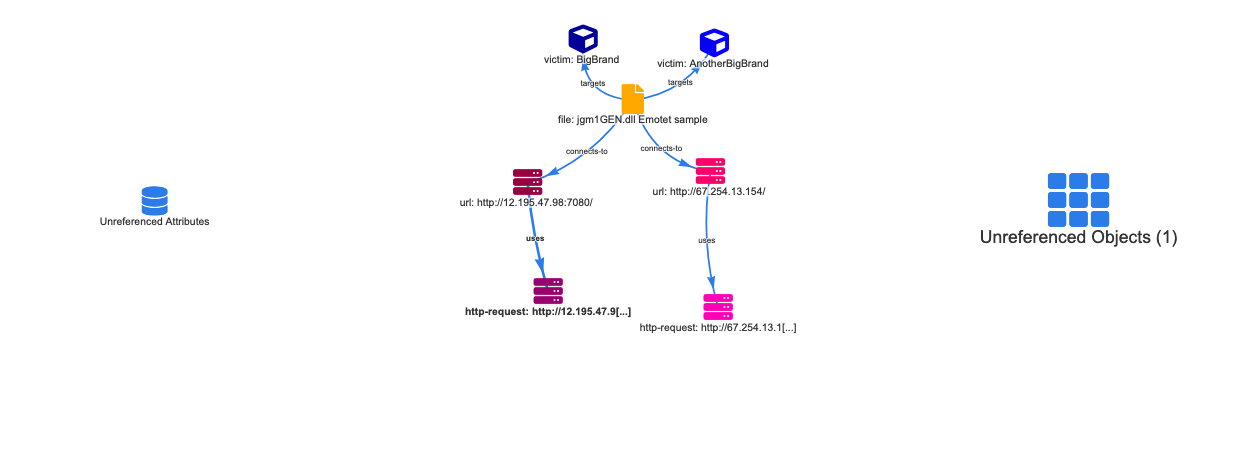

In [23]:
# Start with the first MISP Event graph
misp_eventgraph_id = 6

# We use the requests library and need to set the headers
misp_headers = {"Authorization": misp_key,  "Content-Type": "application/json", "Accept": "application/json"}
event_graph = requests.get("{}/event_graph/viewPicture/{}/{}".format(misp_url, misp_event.id, misp_eventgraph_id), headers=misp_headers, verify=misp_verifycert)
if event_graph.status_code == 200:
    display(Image(event_graph.content, width=480))
else:
    print("Event \033[91mgraph not found\033[90m. Continue with the playbook.\n\n")

# Extending MISP objects

## EX:1 Extending the default list of MISP objects

So far we used the MISP object definitions that are part of your MISP server. Similar to taxonomies or warninglists the MISP objects are based on JSON and are stored in the folder `MISP/app/files/misp-objects/`.

Despite the large list of available objects it’s always possible that they do not fully address your need. You can then choose to add a custom MISP object as a JSON file. This is document on the MISP project blog post [Creating a MISP object 101](https://www.misp-project.org/2021/03/17/MISP-Objects-101.html/) and in the MISP training slides for the [MISP Object Templates](https://www.misp-project.org/misp-training/3.3-misp-object-template.pdf). The advantage of adding new object types via a JSON file is that you can share them with the entire community via the GitHub repository (do a simple pull request) or share them directly with your partners in your MISP community.

In some cases though maybe you just want to indicate the contextually relation between attributes via an attribute, without creating a full JSON definition of an object. MISP has a flexible way for you to do this rather quicky.

## EX:2 Add custom MISP objects 

Adding custom MISP objects via PyMISP requires you to first generate a default object with `GenericObjectGenerator`. In our playbook we add a custom MISP object **victim-asset** (defined via `custom_object_name`) that includes the details of the affected victim endpoint. We also specify its description (`custom_object_description`) and meta category (`custom_object_meta_category`).

We define the list of custom attributes that are part of the object via a dictionary, in this example `custom_object_attributes` which we then transform to a list of attributes with the function `generate_attributes`. As you see in the example below `custom_object_attributes` is a list of dictionary elements, each describing the attribute type and value that is going to be added to our custom MISP object.

In [19]:
# Custom MISP object attributes
custom_object_attributes = [{'internal-ip': {'value': '192.168.1.1', 'type': 'ip-src'}},
                   {'asset-owner': {'value': 'John', 'type': 'text'}}]
custom_object_name = "victim-asset"
custom_object_description = "Victim asset information"
custom_object_meta_category = "asset-info"

In [20]:
# Create the custom MISP object and attach it to the MISP event
misp_object = GenericObjectGenerator(custom_object_name)
misp_object.generate_attributes(custom_object_attributes)
misp_object.template_uuid = uuid4()
misp_object.template_version = 1
misp_object.description = custom_object_description
setattr(misp_object, 'meta-category', custom_object_meta_category)
victim_asset = misp.add_object(misp_event.uuid, misp_object, pythonify=True)

print("\033[92mAdded victim asset object\033[90m {}.\n\n".format(victim_asset.uuid))

Added victim asset object f7c04045-651e-4745-a033-6f9083330cb3.




![helpers/playbook-create_MISP_objects_and_relationships_customobject.png](helpers/playbook-create_MISP_objects_and_relationships_customobject.png)

## EX:3 Update custom MISP objects  

It can happen that you do not have all the object (in this case the victim) details at once. Obviously it's also to update the custom MISP object with PyMISP and add an additional attribute to it.

In [21]:
misp_object.add_attribute('department', value='HR', type='text', to_ids=False)
victim_asset = misp.update_object(misp_object, pythonify=True)

print("\033[92mUpdated victim asset object\033[90m {}.\n\n".format(victim_asset.uuid))

Updated victim asset object f7c04045-651e-4745-a033-6f9083330cb3.




## EX:4 Update the custom MISP object via the web user interface 

There is one downside on adding these custom objects to MISP via PyMISP, without creating a JSON constructs. Although you can edit the objects very easily via PyMISP, it's not possible to edit them afterwards via the MISP web user interface. When you try to edit the object you will get an error message: `Object cannot be edited, no valid template found.`.

To resolve this you should add the object template (as created in the previous cells) to your MISP server as a JSON file.

## EX:5 Delete objects from an event 

Adding and updating objects is fine but there might be a time where you want to delete an object. Deleting objects is easy if you have their **UUID** and then use `delete_object`. The next cell deletes our custom MISP object.

In [24]:
result = misp.delete_object(victim_asset.uuid)
print("\033[92mDeleted victim asset object\033[90m {} {}.\n\n".format(victim_asset.uuid, result))

Deleted victim asset object f7c04045-651e-4745-a033-6f9083330cb3 {'saved': True, 'success': True, 'name': 'Object deleted', 'message': 'Object deleted', 'url': '/objects/delete/2590', 'id': '2590'}.




# Summary

## EN:1 MISP indicators 

The next section first **queries MISP for the indicators added to the MISP event** that is linked to the execution of this playbook.

### Get indicators

The indicators are stored in the variable `indicator_table` (table format) and `indicator_raw_list` (in raw format) which is used in a later section to create the playbook summary.

In [25]:
indicator_search = misp.search("attributes", uuid=misp_event.uuid, to_ids=True, pythonify=True)
indicator_raw_list = []
indicator_table = PrettyTable()
if len(indicator_search) > 0:
    indicator_table.field_names = ["Type", "Category", "Indicator", "Comment"]
    indicator_table.align["Type"] = "l"
    indicator_table.align["Category"] = "l"
    indicator_table.align["Indicator"] = "l"
    indicator_table.align["Comment"] = "l"
    indicator_table.border = True
    for indicator in indicator_search:
        if indicator.value not in indicator_raw_list:
            indicator_table.add_row([indicator.type, indicator.category, indicator.value, indicator.comment])
            indicator_raw_list.append(indicator.value)
    print("Got \033[92m{}\033[90m indicator(s) from the event \033[92m{}\033[90m ({}).\n\n".format(len(indicator_raw_list), misp_event.info, misp_event.id))
else:
    print("\033[93mNo indicators found in the event \033[92m{}\033[90m ({})".format(misp_event.info, misp_event.id))

Got 6 indicator(s) from the event Demo Event Create MISP objects and relations (2590).




### Print indicators

The indicators are now stored in `indicator_search` (as Python objects) and `indicator_raw_list` (in raw format, only the indicators). Execute the next cell to display them in a table format. The table is also included in the summary.

In [26]:
if len(indicator_raw_list) > 0:
    print(indicator_table.get_string(sortby="Type"))
    print("\n\nIndicator list in raw format:")
    print("---------------------------------------------------")
    for el in indicator_raw_list:
        print("{}".format(el))
    print("---------------------------------------------------")

+--------+------------------+------------------------------------------------------------------+---------+
| Type   | Category         | Indicator                                                        | Comment |
+--------+------------------+------------------------------------------------------------------+---------+
| domain | Network activity | 12.195.47.98                                                     |         |
| domain | Network activity | 67.254.13.154                                                    |         |
| md5    | Payload delivery | 8b3f3e3028c5c934654509cb18307dc7                                 |         |
| sha256 | Payload delivery | 14c829d93436c24a6c271b53dbf80f2c4419b30698aee78558c8f5494ad12c96 |         |
| url    | Network activity | http://12.195.47.98:7080/                                        |         |
| url    | Network activity | http://67.254.13.154/                                            |         |
+--------+------------------+--------

## EN:2 Create the summary of the playbook 

The next section creates a summary and stores the output in the variable `summary` in Markdown format. It also stores an intro text in the variable `intro`. These variables can later be used when sending information to Mattermost or TheHive. For this playbook we limit ourselves to printing out the summary. You can find examples on how to interact with Mattermost or TheHive in other playbooks.

In [27]:
summary = "## MISP Playbook summary\nThe investigation concerned MISP event: **{}** ({}/events/view/{}). ".format(misp_event.info, misp_url, misp_event.id)

intro = summary
summary += "\n\n"
summary += "### Indicators\n"
if len(indicator_raw_list) > 0:
    indicator_table.set_style(MARKDOWN)
    summary += indicator_table.get_string(sortby="Type")
    summary += "\n\n\n" 
    summary += "Indicators in **raw format** \n\n"
    for el in indicator_raw_list:
        summary += "{} \n\n".format(el)
    summary += "\n" 
else:
    summary += "There are no indicators"

summary += "### Objects\n"
summary += "File object {} is added.\n".format(playbook_objects["emotet_sample"].uuid)
if len(case_details["filename"]) > 0:
    summary += " - Filename **{}**\n".format(case_details["filename"])
if len(case_details["md5"]) > 0:
    summary += " - MD5 **{}**\n".format(case_details["md5"])
if len(case_details["sha256"]) > 0:
    summary += " - SHA256 **{}**\n".format(case_details["sha256"])
summary += "\n\n"
for request in playbook_objects["requests"]:
    for attr in request["url"].attributes:
        if attr.object_relation == "url":
            url = attr.value
            break    
    summary += "Network objects for **{}**\n".format(url)
    summary += " - URL object {} added.\n".format(request["url"].uuid)
    summary += " - HTTP-Request object {} added.\n".format(request["http-request"].uuid)
    summary += "\n"   
    
summary += "\n\n"
print("The \033[92msummary\033[90m of the playbook is available.\n")

The summary of the playbook is available.



## EN:3 Print the summary of the playbook 

Print the summary of the playbook in Markdown format.

In [28]:
display_markdown(summary, raw=True)

## MISP Playbook summary
The investigation concerned MISP event: **Demo Event Create MISP objects and relations** (https://misp.demo.cudeso.be//events/view/2590). 

### Indicators
| Type   | Category         | Indicator                                                        | Comment |
|:-------|:-----------------|:-----------------------------------------------------------------|:--------|
| domain | Network activity | 12.195.47.98                                                     |         |
| domain | Network activity | 67.254.13.154                                                    |         |
| md5    | Payload delivery | 8b3f3e3028c5c934654509cb18307dc7                                 |         |
| sha256 | Payload delivery | 14c829d93436c24a6c271b53dbf80f2c4419b30698aee78558c8f5494ad12c96 |         |
| url    | Network activity | http://12.195.47.98:7080/                                        |         |
| url    | Network activity | http://67.254.13.154/                                            |         |


Indicators in **raw format** 

8b3f3e3028c5c934654509cb18307dc7 

14c829d93436c24a6c271b53dbf80f2c4419b30698aee78558c8f5494ad12c96 

http://12.195.47.98:7080/ 

12.195.47.98 

http://67.254.13.154/ 

67.254.13.154 


### Objects
File object 7a7fa48d-7fbd-4fb8-a929-4b7ab6ea5784 is added.
 - Filename **jgm1GEN.dll**
 - MD5 **8b3f3e3028c5c934654509cb18307dc7**
 - SHA256 **14c829d93436c24a6c271b53dbf80f2c4419b30698aee78558c8f5494ad12c96**


Network objects for **http://12.195.47.98:7080/**
 - URL object 7b045176-c810-4dc9-8e41-13ca71546925 added.
 - HTTP-Request object 8ff19eae-4916-4e50-96be-5340a8ee81ff added.

Network objects for **http://67.254.13.154/**
 - URL object a3aa2d27-cfbb-41ee-9ac2-fdfbaf2acee0 added.
 - HTTP-Request object 5e83976c-9044-46d9-8a0c-5db3f1079d7f added.





## EN:4 Publish MISP event 

As a final step, you can choose the **publish** the MISP event. Publishing MISP events makes the event available to your users and, depending on the synchronisation and distribution rules, will also sync it with other connected MISP servers. Publishing an event also typically makes the indicators available for your security controls to import them in their ruleset.

This step will remove the **workflow** states incomplete, add a workflow state complete and then publish the event.

In [29]:
try:
    misp.untag(misp_event.uuid, "workflow:state=\"incomplete\"")
    misp.tag(misp_event.uuid, "workflow:state=\"complete\"", local=True)
    print(misp.publish(misp_event.uuid))
    print("Event {} ({} - {}) is \033[92mpublished.\n".format(misp_event.info, misp_event.id, misp_event.uuid))
except:
    print("\033[91mFailed to publish\033[90m event {} ({} - {}).\n".format(misp_event.info, misp_event.id, misp_event.uuid))

{'saved': True, 'success': True, 'name': 'Job queued', 'message': 'Job queued', 'url': '/events/publish/2590', 'id': '2590'}
Event Demo Event Create MISP objects and relations (2590 - ead00dd5-1fc0-4c4f-93bf-0b95edcb4433) is published.



## EN:5 End of the playbook

In [30]:
print("\033[92m End of the playbook\n\n")

 End of the playbook




## External references 

- [The MISP Project](https://www.misp-project.org/)
- [MISP Objects](https://www.misp-project.org/objects.html)
- [MISP Objects GitHub repository](https://github.com/MISP/misp-objects)
- [MISP Object Template training](https://www.misp-project.org/misp-training/3.3-misp-object-template.pdf)
- [Creating a MISP Object 101](https://www.misp-project.org/2021/03/17/MISP-Objects-101.html/)
- [Traffic Light Protocol](https://www.first.org/tlp/)
- [Permissible Actions Protocol and Course of Action matrix](https://www.vanimpe.eu/2020/12/28/how-to-support-defenders-with-the-permissible-actions-protocol/)

## Technical details 

### Documentation

This playbook requires these Python **libraries** to exist in the environment where the playbook is executed. You can install them with `pip install <library>`.

```
pyfaup
chardet
PrettyTable
ipywidgets
```

You need to have **network access** to 
- your MISP server (HTTP or HTTPS)

You need
- an **API key with MISP**
- - Under Global Actions, My Profile. Add an extra authentication key.
- - Add the API key (`misp_key`) and the MISP URL (`misp_url`) to `keys.py`
- - If you use a self-signed certificate set `misp_verifycert` to False

### Helper functions

#### pb_print_object_definition
```
def pb_print_object_definition(misp, object_template):
    '''
    Print the raw object template

    :param misp: MISP object
    :param object_template: which object template to return
    '''
```

#### pb_get_misp_tags
```
def pb_get_misp_tags(tags=[], local_tags=[]):
    '''
    Get a list of MISP tags based on a Python list

    :param misp: MISP object
    :param object_template: which object template to return
    '''
```

### Colour codes

The output from Python displays some text in different colours. These are the colour codes

```
Red = '\033[91m'
Green = '\033[92m'
Blue = '\033[94m'
Cyan = '\033[96m'
White = '\033[97m'
Yellow = '\033[93m'
Magenta = '\033[95m'
Grey = '\033[90m'
Black = '\033[90m'
Default = '\033[99m'
```